<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Workflow (Clean-Clean) Entity Resolution</b> </font>
   <hr>
</div>

In [1]:
import os
import sys
import pandas as pd
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Data Reading

In [2]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("../data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("../data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("../data/ccer/D2/gt.csv", sep='|', engine='python'),
)

[nltk_data] Downloading package stopwords to /home/jm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## WorkFlow

In [3]:
from pyjedai.workflow import BlockingBasedWorkFlow, EmbeddingsNNWorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

/home/conda/miniconda3/envs/pyjedai-progressive/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
w = BlockingBasedWorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=3)
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.8)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
    entity_matching = dict(
        method=EntityMatching, 
        params=dict(
            metric='edit_distance',
            similarity_threshold=0.5,
        )
    ),
    clustering = dict(method=ConnectedComponentsClustering),
    name="Worflow-Test"
)

In [5]:
w.run(data, verbose=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 3
Runtime: 0.3088 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.02% 
	Recall:       100.00%
	F1-score:       0.04%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Filtering
************************************************************************************

In [6]:
w.to_df()

,Algorithm,F1,Recall,Precision,Runtime (sec),Params
0,Q-Grams Blocking,0.041583,100.000000,0.020796,0.308826,{'Q-Gramms': 3}
1,Block Filtering,0.103805,100.000000,0.051929,0.142960,{'Ratio': 0.8}
2,Block Purging,0.103805,100.000000,0.051929,0.010554,"{'Smoothing factor': 1.025, 'Max Comparisons p..."
3,Cardinality Edge Pruning,3.383094,98.884758,1.720987,1.863479,"{'Node centric': False, 'Weighting scheme': 'JS'}"
4,Entity Matching,0.556070,0.278810,100.000000,78.866450,"{'Metric': 'edit_distance', 'Attributes': None..."
5,Connected Components Clustering,0.556070,0.278810,100.000000,0.000176,{}


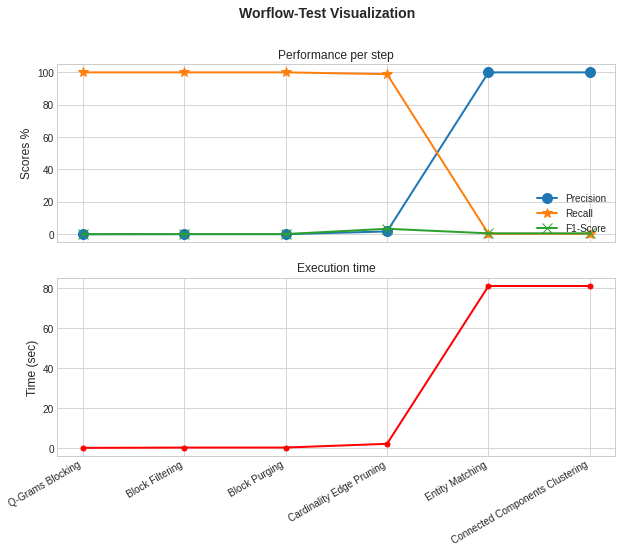

In [7]:
w.visualize()

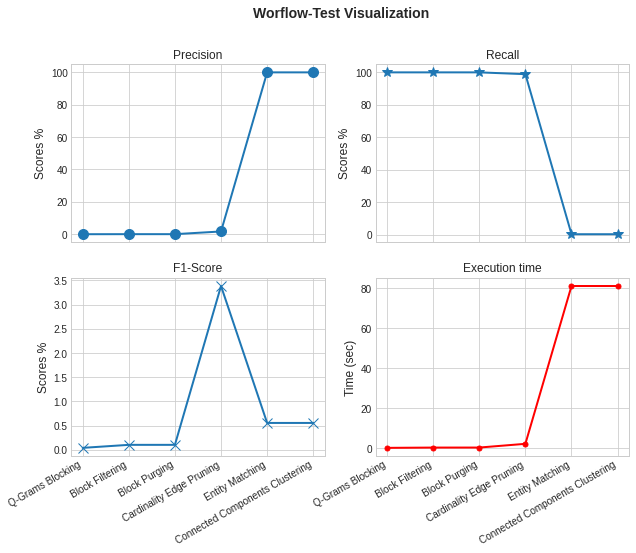

In [8]:
w.visualize(separate=True)

# Predefined workflows (best & default)

In [9]:
w = BlockingBasedWorkFlow()
w.default_blocking_workflow_ccer()
w.run(data, verbose=True)

***************************************************************************************************************************
                                         Μethod:  Standard Blocking
***************************************************************************************************************************
Method name: Standard Blocking
Parameters: 
Runtime: 0.1625 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.12% 
	Recall:        99.81%
	F1-score:       0.24%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Purging
*************************************************************************************************

## Workflow based on pyTorch Embdeddings


- `block_building` : 
    - `method` : EmbeddingsNNBlockBuilding
    - `params` : Constructor parameters
    - `exec_params` : `build_blocks` parameters
- `clustering` : 
    - `method` : UniqueMappingClustering
    - `params` : Constructor parameters (i.e similarity threshold)

In [10]:
w = EmbeddingsNNWorkFlow(
    block_building = dict(
        method=EmbeddingsNNBlockBuilding, 
        params=dict(vectorizer='sminilm', similarity_search='faiss'),
        exec_params=dict(top_k=5, 
                         similarity_distance='euclidean',
                         load_embeddings_if_exist=False,
                         save_embeddings=False)
    ),
    clustering = dict(method=UniqueMappingClustering),
    name="EmbeddingsNNWorkFlow-Test"
)

w.run(data, verbose=True)

Building blocks via Embeddings-NN Block Building [sminilm, faiss]


Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cuda


Embeddings-NN Block Building [sminilm, faiss]: 100%|██████████| 2152/2152 [00:20<00:00, 103.72it/s]


***************************************************************************************************************************
                                         Μethod:  Embeddings-NN Block Building
***************************************************************************************************************************
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: sminilm
	Similarity-Search: faiss
	Top-K: 5
	Vector size: 384
Runtime: 20.7496 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      9.17% 
	Recall:        91.73%
	F1-score:      16.68%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Unique Mappin

## Multiple workflows - Comparison

In [11]:
w1 = BlockingBasedWorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=4),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.6)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
    entity_matching = dict(
        method=EntityMatching, 
        params=dict(
            metric='dice',
            similarity_threshold=0.5,
        )
    ),
    clustering = dict(method=ConnectedComponentsClustering)
)
w1.run(data, verbose=True, workflow_tqdm_enable=False)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 4
Runtime: 0.1699 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.17% 
	Recall:       100.00%
	F1-score:       0.34%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Filtering
************************************************************************************

In [12]:
w2 = BlockingBasedWorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=4),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.6)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
    entity_matching = dict(
        method=EntityMatching,
        params=dict(
            metric='edit_distance',
            similarity_threshold=0.5,
        )
    ),
    clustering = dict(method=ConnectedComponentsClustering)
)
w2.run(data, verbose=True, workflow_tqdm_enable=False)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 4
Runtime: 0.1754 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.17% 
	Recall:       100.00%
	F1-score:       0.34%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
***************************************************************************************************************************
                                         Μethod:  Block Filtering
************************************************************************************

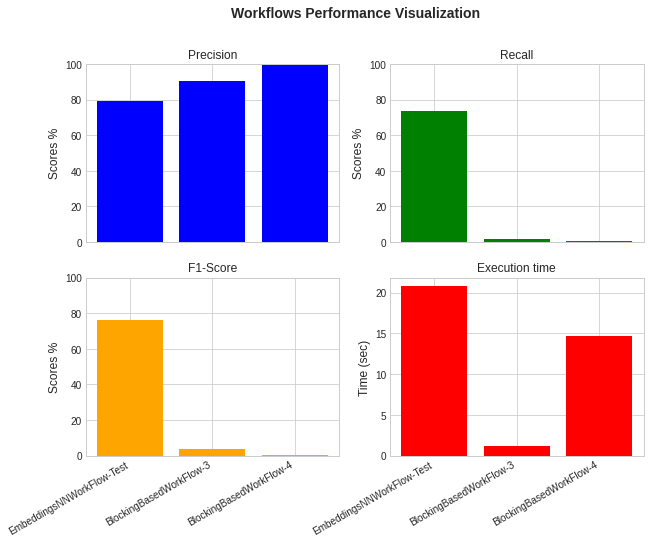

,Name,F1,Recall,Precision,Runtime (sec)
0,EmbeddingsNNWorkFlow-Test,76.410999,73.605948,79.438315,20.805880
1,BlockingBasedWorkFlow-3,3.463993,1.765799,90.476190,1.183336
2,BlockingBasedWorkFlow-4,0.556070,0.278810,100.000000,14.639766


In [13]:
compare_workflows([w, w1, w2], with_visualization=True)

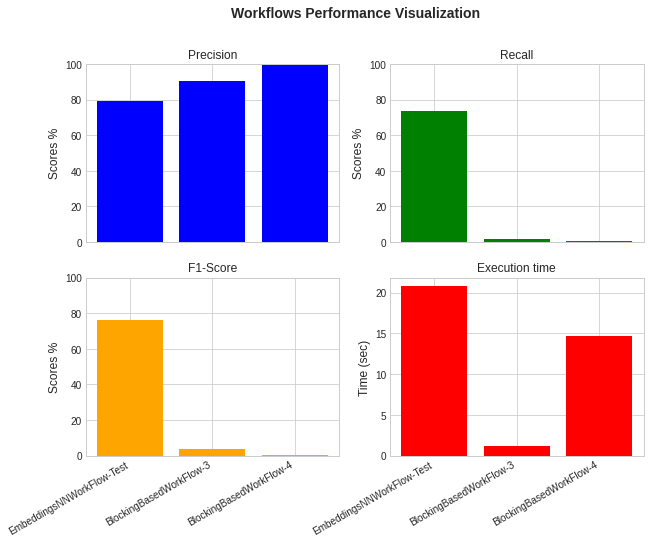

,Name,F1,Recall,Precision,Runtime (sec)
0,EmbeddingsNNWorkFlow-Test,76.410999,73.605948,79.438315,20.805880
1,BlockingBasedWorkFlow-3,3.463993,1.765799,90.476190,1.183336
2,BlockingBasedWorkFlow-4,0.556070,0.278810,100.000000,14.639766


In [14]:
compare_workflows([w, w1, w2], with_visualization=True)